In [1]:
# if you are in the root folder, don't run this line
import os

os.chdir("..")
os.getcwd()

'/home/jibancat/Documents/PYTHON/emu_optimizer'

In [2]:
from typing import List

import numpy as np
from matplotlib import pyplot as plt
import matplotlib

from matter_multi_fidelity_emu.gpemulator_singlebin import (
    SingleBinGP,
    SingleBinLinearGP,
    SingleBinNonLinearGP,
)
from matter_multi_fidelity_emu.data_loader import PowerSpecs

# set a random number seed to reproducibility
np.random.seed(0)

from itertools import combinations

from trainset_optimize.optmize import TrainSetOptimize

In [3]:
def generate_data(folder: str = "data/50_dmonly_50_fullphysics/"):
    data = PowerSpecs(folder=folder)
    return data

## Find the HR choices

In [28]:
# acquire data object, the text files 
data = generate_data()

i_fidelity = 1

X = data.X_train_norm[i_fidelity]
Y = data.Y_train[i_fidelity]

train_opt = TrainSetOptimize(X=X, Y=Y)

# find the optimal two indices first;
# looking for all possible combinations
num_samples, _ = data.X_train[0].shape
num_selected = 2

all_combinations = list(combinations(range(num_samples), num_selected))

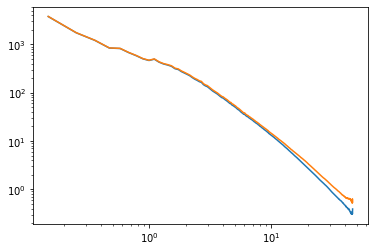

In [29]:
plt.loglog(10**data.kf, 10**data.Y_train[0][0])
plt.loglog(10**data.kf, 10**data.Y_train[1][0])

In [30]:
# loop over to get the least loss 2 indices
all_loss = []

for i,selected_index in enumerate(all_combinations):

    # need to convert to boolean array
    ind = np.zeros(num_samples, dtype=np.bool)
    ind[np.array(selected_index)] = True

    loss = train_opt.loss(ind)
    
    print("iteration:", i)

    all_loss.append(loss)

Optimization restart 1/5, f = 246.22450558875494
Optimization restart 2/5, f = 246.22450558875516
Optimization restart 3/5, f = 246.22450558881098
Optimization restart 4/5, f = 246.22450558890262
Optimization restart 5/5, f = 246.22450558875505
iteration: 0
Optimization restart 1/5, f = 701.6926717394579
Optimization restart 2/5, f = 701.6926717360825
Optimization restart 3/5, f = 701.6926717362497
Optimization restart 4/5, f = 701.6926717359202
Optimization restart 5/5, f = 701.6926717359538
iteration: 1
Optimization restart 1/5, f = 279.22039799137247
Optimization restart 2/5, f = 279.2203979913942
Optimization restart 3/5, f = 279.2203979913801
Optimization restart 4/5, f = 279.22039799163394
Optimization restart 5/5, f = 279.22039799144716
iteration: 2
Optimization restart 1/5, f = -350.24943230205713
Optimization restart 2/5, f = -350.2494323020619
Optimization restart 3/5, f = 1252.1834019192156
Optimization restart 4/5, f = -350.2494322388825
Optimization restart 5/5, f = -350.2

Optimization restart 1/5, f = -308.25564266542096
Optimization restart 2/5, f = -308.255642664926
Optimization restart 3/5, f = -308.25564266406195
Optimization restart 4/5, f = 1234.0133548464378
Optimization restart 5/5, f = -308.2556426317501
iteration: 32
Optimization restart 1/5, f = 108.62980478617624
Optimization restart 2/5, f = 108.62980478561462
Optimization restart 3/5, f = 108.6298047856144
Optimization restart 4/5, f = 108.62980478566487
Optimization restart 5/5, f = 108.62980478562554
iteration: 33
Optimization restart 1/5, f = 104.51259468496096
Optimization restart 2/5, f = 104.51259468402486
Optimization restart 3/5, f = 104.51259468405738
Optimization restart 4/5, f = 104.51259468399348
Optimization restart 5/5, f = 104.51259470060381
iteration: 34
Optimization restart 1/5, f = 288.41169294206486
Optimization restart 2/5, f = 288.41169294075087
Optimization restart 3/5, f = 288.41169293972837
Optimization restart 4/5, f = 288.4116929685681
Optimization restart 5/5, f 

Optimization restart 3/5, f = 315.5834455495673
Optimization restart 4/5, f = 315.5834455572831
Optimization restart 5/5, f = 315.58344554963026
iteration: 64
Optimization restart 1/5, f = 157.2777581026217
Optimization restart 2/5, f = 157.2777581026262
Optimization restart 3/5, f = 157.27775811138468
Optimization restart 4/5, f = 157.27775810261943
Optimization restart 5/5, f = 157.27775810382354
iteration: 65
Optimization restart 1/5, f = 297.78187229757714
Optimization restart 2/5, f = 1110.6067497006948
Optimization restart 3/5, f = 297.7818722911678
Optimization restart 4/5, f = 297.78187229057266
Optimization restart 5/5, f = 297.7818722905789
iteration: 66
Optimization restart 1/5, f = 420.9429488890076
Optimization restart 2/5, f = 420.9429488886478
Optimization restart 3/5, f = 420.94294888889397
Optimization restart 4/5, f = 420.9429488915522
Optimization restart 5/5, f = 420.9429488887073
iteration: 67
Optimization restart 1/5, f = 514.6189340463959
Optimization restart 2/5

Optimization restart 1/5, f = 489.7027295810948
Optimization restart 2/5, f = 489.7027295801337
Optimization restart 3/5, f = 489.70272958003534
Optimization restart 4/5, f = 1082.9790048504544
Optimization restart 5/5, f = 489.7027295807301
iteration: 97
Optimization restart 1/5, f = 724.96841819619
Optimization restart 2/5, f = 724.9684181940378
Optimization restart 3/5, f = 724.968418193971
Optimization restart 4/5, f = 724.9684182046242
Optimization restart 5/5, f = 724.9684181941726
iteration: 98
Optimization restart 1/5, f = -285.21552912113
Optimization restart 2/5, f = -285.21552912437755
Optimization restart 3/5, f = -285.21552912440825
Optimization restart 4/5, f = -285.21552821075784
Optimization restart 5/5, f = -285.21552912413654
iteration: 99
Optimization restart 1/5, f = 116.61551814235577
Optimization restart 2/5, f = 116.61551814235372
Optimization restart 3/5, f = 116.6155181433844
Optimization restart 4/5, f = 116.61551814235872
Optimization restart 5/5, f = 116.615

Optimization restart 1/5, f = 484.9110175351736
Optimization restart 2/5, f = 484.9110175351517
Optimization restart 3/5, f = 484.91101753572497
Optimization restart 4/5, f = 484.9110175351195
Optimization restart 5/5, f = 484.9110175351937
iteration: 130
Optimization restart 1/5, f = -196.03131684456707
Optimization restart 2/5, f = -196.0313168445532
Optimization restart 3/5, f = -196.03131684296773
Optimization restart 4/5, f = -196.0313168445614
Optimization restart 5/5, f = -196.03131684456594
iteration: 131
Optimization restart 1/5, f = 308.7761842427368
Optimization restart 2/5, f = 308.7761842428662
Optimization restart 3/5, f = 308.77618424486815
Optimization restart 4/5, f = 308.77618424483285
Optimization restart 5/5, f = 308.776184243907
iteration: 132
Optimization restart 1/5, f = 586.6969885806998
Optimization restart 2/5, f = 586.6969885806116
Optimization restart 3/5, f = 586.6969885831313
Optimization restart 4/5, f = 586.6969885806113
Optimization restart 5/5, f = 586

Optimization restart 2/5, f = 496.3154779976927
Optimization restart 3/5, f = 496.3154779983405
Optimization restart 4/5, f = 496.3154779974367
Optimization restart 5/5, f = 496.3154779975549
iteration: 162
Optimization restart 1/5, f = 409.3717006744806
Optimization restart 2/5, f = 409.3717006711006
Optimization restart 3/5, f = 409.3717006706207
Optimization restart 4/5, f = 409.3717006709305
Optimization restart 5/5, f = 409.3717006706029
iteration: 163
Optimization restart 1/5, f = -198.58965203450907
Optimization restart 2/5, f = -198.58965203717264
Optimization restart 3/5, f = -198.58965203717787
Optimization restart 4/5, f = -198.58965203717594
Optimization restart 5/5, f = -198.58965203193793
iteration: 164
Optimization restart 1/5, f = -29.411629653879572
Optimization restart 2/5, f = -29.411629653929594
Optimization restart 3/5, f = -29.411629653906857
Optimization restart 4/5, f = -29.41162965392732
Optimization restart 5/5, f = -29.411629653722002
iteration: 165
Optimizat

Optimization restart 3/5, f = 464.7250414783972
Optimization restart 4/5, f = 464.72504147839766
Optimization restart 5/5, f = 464.7250414871238
iteration: 194
Optimization restart 1/5, f = 214.06351074533063
Optimization restart 2/5, f = 214.0635107460564
Optimization restart 3/5, f = 214.06351074614327
Optimization restart 4/5, f = 214.0635107492435
Optimization restart 5/5, f = 1223.2818792421858
iteration: 195
Optimization restart 1/5, f = -186.3797071451056
Optimization restart 2/5, f = -186.37970714510334
Optimization restart 3/5, f = -186.37970714510493
Optimization restart 4/5, f = 1245.634768093511
Optimization restart 5/5, f = -186.37970714510243
iteration: 196
Optimization restart 1/5, f = 142.15768887407967
Optimization restart 2/5, f = 142.15768887327636
Optimization restart 3/5, f = 142.15768887328477
Optimization restart 4/5, f = 142.1576888744696
Optimization restart 5/5, f = 142.15768887328272
iteration: 197
Optimization restart 1/5, f = -304.868608057405
Optimization 

Optimization restart 1/5, f = 547.6768166268015
Optimization restart 2/5, f = 547.6768166233062
Optimization restart 3/5, f = 547.6768166217428
Optimization restart 4/5, f = 547.6768166219923
Optimization restart 5/5, f = 547.676816621621
iteration: 227
Optimization restart 1/5, f = 319.6270726502511
Optimization restart 2/5, f = 319.62707265024517
Optimization restart 3/5, f = 319.6270726748818
Optimization restart 4/5, f = 1208.432007651617
Optimization restart 5/5, f = 1208.4320076514327
iteration: 228
Optimization restart 1/5, f = 409.2332326902973
Optimization restart 2/5, f = 409.2332326902873
Optimization restart 3/5, f = 409.2332326904349
Optimization restart 4/5, f = 409.23323269080095
Optimization restart 5/5, f = 409.23323269130674
iteration: 229
Optimization restart 1/5, f = -188.79387070873008
Optimization restart 2/5, f = -188.7938707087551
Optimization restart 3/5, f = -188.79387070875237
Optimization restart 4/5, f = -188.7938707087519
Optimization restart 5/5, f = -188

Optimization restart 1/5, f = 616.2781561837546
Optimization restart 2/5, f = 616.2781561867557
Optimization restart 3/5, f = 616.2781561837544
Optimization restart 4/5, f = 616.2781561860529
Optimization restart 5/5, f = 616.2781561854041
iteration: 260
Optimization restart 1/5, f = 730.7938692819256
Optimization restart 2/5, f = 730.7938692793766
Optimization restart 3/5, f = 730.7938692797179
Optimization restart 4/5, f = 730.7938692793771
Optimization restart 5/5, f = 730.7938692959101
iteration: 261
Optimization restart 1/5, f = 712.3334490271151
Optimization restart 2/5, f = 712.3334490275035
Optimization restart 3/5, f = 712.3334490271154
Optimization restart 4/5, f = 1117.1979430640306
Optimization restart 5/5, f = 712.3334490271133
iteration: 262
Optimization restart 1/5, f = 632.2728069544548
Optimization restart 2/5, f = 632.272806954384
Optimization restart 3/5, f = 632.2728069545057
Optimization restart 4/5, f = 632.2728069544506
Optimization restart 5/5, f = 632.272806954

Optimization restart 3/5, f = -206.67242265093637
Optimization restart 4/5, f = -206.672422650925
Optimization restart 5/5, f = -206.67242265093614
iteration: 292
Optimization restart 1/5, f = 101.51197923774487
Optimization restart 2/5, f = 101.51197923767268
Optimization restart 3/5, f = 101.51197923762004
Optimization restart 4/5, f = 101.51197923761936
Optimization restart 5/5, f = 101.5119792377103
iteration: 293
Optimization restart 1/5, f = 694.2580973547035
Optimization restart 2/5, f = 694.2580973547932
Optimization restart 3/5, f = 694.2580973569252
Optimization restart 4/5, f = 694.258097354663
Optimization restart 5/5, f = 694.2580973546766
iteration: 294
Optimization restart 1/5, f = 642.3436608198284
Optimization restart 2/5, f = 642.3436608173643
Optimization restart 3/5, f = 642.343660817485
Optimization restart 4/5, f = 642.3436608177935
Optimization restart 5/5, f = 642.3436608224217
iteration: 295
Optimization restart 1/5, f = 357.0119756534091
Optimization restart 2

Optimization restart 2/5, f = -305.60696992541966
Optimization restart 3/5, f = -305.60696990853694
Optimization restart 4/5, f = -305.60696992604335
Optimization restart 5/5, f = -305.60696992597036
iteration: 325
Optimization restart 1/5, f = 50.119831399959594
Optimization restart 2/5, f = 50.11983139848189
Optimization restart 3/5, f = 50.11983139888275
Optimization restart 4/5, f = 50.11983139846279
Optimization restart 5/5, f = 50.119831398466204
iteration: 326
Optimization restart 1/5, f = -703.4736732343874
Optimization restart 2/5, f = -703.4736731311921
Optimization restart 3/5, f = -703.4736732343874
Optimization restart 4/5, f = -703.4736732343849
Optimization restart 5/5, f = -703.4736731967571
iteration: 327
Optimization restart 1/5, f = 781.7450543395764
Optimization restart 2/5, f = 1125.8482344453535
Optimization restart 3/5, f = 781.7450543396455
Optimization restart 4/5, f = 781.7450543393188
Optimization restart 5/5, f = 781.7450543396367
iteration: 328
Optimization

Optimization restart 3/5, f = 263.1900061495015
Optimization restart 4/5, f = 263.19000614660774
Optimization restart 5/5, f = 263.1900061471989
iteration: 357
Optimization restart 1/5, f = 366.2645322461467
Optimization restart 2/5, f = 366.26453224483737
Optimization restart 3/5, f = 366.2645322446291
Optimization restart 4/5, f = 366.2645322445878
Optimization restart 5/5, f = 366.2645322445893
iteration: 358
Optimization restart 1/5, f = -240.02857187108464
Optimization restart 2/5, f = -240.02857187123777
Optimization restart 3/5, f = -240.02857187059067
Optimization restart 4/5, f = -240.028571866045
Optimization restart 5/5, f = -240.02857186581855
iteration: 359
Optimization restart 1/5, f = 208.4993032290397
Optimization restart 2/5, f = 208.49930322778005
Optimization restart 3/5, f = 208.4993032281327
Optimization restart 4/5, f = 208.49930322778278
Optimization restart 5/5, f = 208.49930322959995
iteration: 360
Optimization restart 1/5, f = -195.33059779424798
Optimization 

Optimization restart 1/5, f = 172.86018751641336
Optimization restart 2/5, f = 172.86018751681422
Optimization restart 3/5, f = 172.86018752166387
Optimization restart 4/5, f = 172.86018754205134
Optimization restart 5/5, f = 172.86018752026575
iteration: 390
Optimization restart 1/5, f = 332.00878414393037
Optimization restart 2/5, f = 332.0087841413713
Optimization restart 3/5, f = 332.00878414105296
Optimization restart 4/5, f = 332.00878414095143
Optimization restart 5/5, f = 332.00878414083365
iteration: 391
Optimization restart 1/5, f = 663.9030083770219
Optimization restart 2/5, f = 663.9030083858722
Optimization restart 3/5, f = 663.9030083770203
Optimization restart 4/5, f = 663.9030083774194
Optimization restart 5/5, f = 663.9030083879695
iteration: 392
Optimization restart 1/5, f = 497.6255084017014
Optimization restart 2/5, f = 497.6255084013384
Optimization restart 3/5, f = 497.62550840132576
Optimization restart 4/5, f = 497.62550840132417
Optimization restart 5/5, f = 49

Optimization restart 3/5, f = 268.27231088428005
Optimization restart 4/5, f = 268.27231088670896
Optimization restart 5/5, f = 268.2723108841867
iteration: 422
Optimization restart 1/5, f = -340.1592317669854
Optimization restart 2/5, f = -340.15923166933
Optimization restart 3/5, f = -340.1592317671548
Optimization restart 4/5, f = -340.15923176693855
Optimization restart 5/5, f = -340.15923176584056
iteration: 423
Optimization restart 1/5, f = 340.5976997532956
Optimization restart 2/5, f = 340.597699753292
Optimization restart 3/5, f = 340.5976997534235
Optimization restart 4/5, f = 340.59769975470226
Optimization restart 5/5, f = 340.59769975332256
iteration: 424
Optimization restart 1/5, f = 246.1652277029931
Optimization restart 2/5, f = 246.16522771745588
Optimization restart 3/5, f = 1159.6982126116518
Optimization restart 4/5, f = 246.1652277044966
Optimization restart 5/5, f = 246.16522770299377
iteration: 425
Optimization restart 1/5, f = 91.90400690373394
Optimization rest

Optimization restart 2/5, f = 469.2380692894805
Optimization restart 3/5, f = 469.238069283484
Optimization restart 4/5, f = 469.2380692833038
Optimization restart 5/5, f = 469.23806936200265
iteration: 454
Optimization restart 1/5, f = 555.4075453893292
Optimization restart 2/5, f = 555.4075453893286
Optimization restart 3/5, f = 555.4075453893287
Optimization restart 4/5, f = 555.4075453894184
Optimization restart 5/5, f = 555.4075453893392
iteration: 455
Optimization restart 1/5, f = 418.3597230717146
Optimization restart 2/5, f = 418.35972307441705
Optimization restart 3/5, f = 418.3597230728018
Optimization restart 4/5, f = 418.35972307171505
Optimization restart 5/5, f = 418.3597230717286
iteration: 456
Optimization restart 1/5, f = 315.9152506592012
Optimization restart 2/5, f = 315.9152506591479
Optimization restart 3/5, f = 1225.3311681208263
Optimization restart 4/5, f = 315.91525065917085
Optimization restart 5/5, f = 315.9152506591614
iteration: 457
Optimization restart 1/5

Optimization restart 1/5, f = 53.26442407163768
Optimization restart 2/5, f = 53.264424071891426
Optimization restart 3/5, f = 53.26442407162722
Optimization restart 4/5, f = 53.26442407164541
Optimization restart 5/5, f = 53.26442407162676
iteration: 487
Optimization restart 1/5, f = 276.98707245578237
Optimization restart 2/5, f = 276.9870724532559
Optimization restart 3/5, f = 276.9870724543333
Optimization restart 4/5, f = 276.9870724535341
Optimization restart 5/5, f = 276.98707245320213
iteration: 488
Optimization restart 1/5, f = -36.2276978266259
Optimization restart 2/5, f = -36.227697826627264
Optimization restart 3/5, f = -36.22769782662817
Optimization restart 4/5, f = -36.22769782662863
Optimization restart 5/5, f = -36.227697826524945
iteration: 489
Optimization restart 1/5, f = 375.3325267767683
Optimization restart 2/5, f = 375.3325267767235
Optimization restart 3/5, f = 375.3325267776162
Optimization restart 4/5, f = 375.33252677672886
Optimization restart 5/5, f = 375

Optimization restart 1/5, f = 274.3172719025175
Optimization restart 2/5, f = 274.31727190244055
Optimization restart 3/5, f = 274.31727190243373
Optimization restart 4/5, f = 274.31727190249705
Optimization restart 5/5, f = 274.3172719024469
iteration: 520
Optimization restart 1/5, f = 127.67828718660417
Optimization restart 2/5, f = 127.67828718625992
Optimization restart 3/5, f = 127.67828718615056
Optimization restart 4/5, f = 127.67828718598935
Optimization restart 5/5, f = 127.67828718599799
iteration: 521
Optimization restart 1/5, f = 7.095009533432403
Optimization restart 2/5, f = 7.095009533424218
Optimization restart 3/5, f = 1215.2207931797611
Optimization restart 4/5, f = 7.095009533421035
Optimization restart 5/5, f = 7.095009533433313
iteration: 522
Optimization restart 1/5, f = 693.1642637315574
Optimization restart 2/5, f = 693.1642637318569
Optimization restart 3/5, f = 693.1642637396327
Optimization restart 4/5, f = 693.1642637315803
Optimization restart 5/5, f = 693.

 /home/jibancat/.pyenv/versions/miniconda3-4.3.31/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 68.39336494914733
iteration: 541
Optimization restart 1/5, f = -176.81252359900805
Optimization restart 2/5, f = -176.81252360104145
Optimization restart 3/5, f = -176.81252360071312
Optimization restart 4/5, f = -176.81252360129452
Optimization restart 5/5, f = -176.81252360072017
iteration: 542
Optimization restart 1/5, f = -586.7201820135765
Optimization restart 2/5, f = -586.7201820135738
Optimization restart 3/5, f = -586.7201820135331
Optimization restart 4/5, f = -586.720182006924
Optimization restart 5/5, f = -586.7201820063426
iteration: 543
Optimization restart 1/5, f = -180.51693038654275
Optimization restart 2/5, f = -180.51693038637063
Optimization restart 3/5, f = -180.51693038676945
Optimization restart 4/5, f = -180.5169303355999
Optimization restart 5/5, f = -180.51693038174346
iteration: 544
Optimization restart 1/5, f = -7.053560416691425
Optimization restart 2/5, f = -7.053560416701885
Optimization restart 3/5, f = -7.053560416702339
Op

Optimization restart 5/5, f = -67.76744951911883
iteration: 574
Optimization restart 1/5, f = -88.49900573134005
Optimization restart 2/5, f = -88.49900573136142
Optimization restart 3/5, f = -88.49900573136301
Optimization restart 4/5, f = -88.49900573136233
Optimization restart 5/5, f = -88.49900572802835
iteration: 575
Optimization restart 1/5, f = 133.5673179104558
Optimization restart 2/5, f = 133.5673179117623
Optimization restart 3/5, f = 133.56731791045468
Optimization restart 4/5, f = 133.56731791052562
Optimization restart 5/5, f = 133.56731791045377
iteration: 576
Optimization restart 1/5, f = -476.7579747432727
Optimization restart 2/5, f = -476.7579747432587
Optimization restart 3/5, f = -476.75797474327055
Optimization restart 4/5, f = -476.75797474253454
Optimization restart 5/5, f = -476.7579747432725
iteration: 577
Optimization restart 1/5, f = -419.7948988749058
Optimization restart 2/5, f = -419.7948988749731
Optimization restart 3/5, f = -419.79489877857986
Optimiza

Optimization restart 5/5, f = 444.31227208476037
iteration: 606
Optimization restart 1/5, f = 168.27379529931204
Optimization restart 2/5, f = 168.27379529996142
Optimization restart 3/5, f = 168.27379529930477
Optimization restart 4/5, f = 168.273795299374
Optimization restart 5/5, f = 168.27379530306928
iteration: 607
Optimization restart 1/5, f = 530.0719539085401
Optimization restart 2/5, f = 530.0719539082685
Optimization restart 3/5, f = 530.0719539082887
Optimization restart 4/5, f = 530.0719539109534
Optimization restart 5/5, f = 530.0719539083015
iteration: 608
Optimization restart 1/5, f = 735.6985081793906
Optimization restart 2/5, f = 735.6985081730629
Optimization restart 3/5, f = 735.6985081764267
Optimization restart 4/5, f = 735.6985081730688
Optimization restart 5/5, f = 735.6985082458459
iteration: 609
Optimization restart 1/5, f = 709.0081320829859
Optimization restart 2/5, f = 709.0081320828615
Optimization restart 3/5, f = 709.0081320828577
Optimization restart 4/5

Optimization restart 1/5, f = 250.80111009142047
Optimization restart 2/5, f = 250.8011100909829
Optimization restart 3/5, f = 250.80111009109442
Optimization restart 4/5, f = 250.80111009094526
Optimization restart 5/5, f = 250.80111009099278
iteration: 640
Optimization restart 1/5, f = 482.6676113131892
Optimization restart 2/5, f = 482.6676113110589
Optimization restart 3/5, f = 482.6676113110915
Optimization restart 4/5, f = 482.66761131105903
Optimization restart 5/5, f = 482.66761131105864
iteration: 641
Optimization restart 1/5, f = 83.56174603525346
Optimization restart 2/5, f = 83.56174603519662
Optimization restart 3/5, f = 83.561746035331
Optimization restart 4/5, f = 83.56174603518048
Optimization restart 5/5, f = 83.56174603521458
iteration: 642
Optimization restart 1/5, f = 65.89237382113834
Optimization restart 2/5, f = 65.8923738211547
Optimization restart 3/5, f = 65.89237382276724
Optimization restart 4/5, f = 65.89237382167994
Optimization restart 5/5, f = 65.8923738

Optimization restart 5/5, f = -96.85378797545559
iteration: 671
Optimization restart 1/5, f = 79.63779670511917
Optimization restart 2/5, f = 79.63779670496592
Optimization restart 3/5, f = 79.63779670546387
Optimization restart 4/5, f = 79.63779670486338
Optimization restart 5/5, f = 79.6377967050546
iteration: 672
Optimization restart 1/5, f = 23.691386356481985
Optimization restart 2/5, f = 23.691386356460725
Optimization restart 3/5, f = 23.691386356880002
Optimization restart 4/5, f = 23.69138635645777
Optimization restart 5/5, f = 23.69138635645777
iteration: 673
Optimization restart 1/5, f = 352.6869020170046
Optimization restart 2/5, f = 352.6869020106908
Optimization restart 3/5, f = 352.6869020117683
Optimization restart 4/5, f = 352.6869020109245
Optimization restart 5/5, f = 352.6869020106542
iteration: 674
Optimization restart 1/5, f = -237.51486652924052
Optimization restart 2/5, f = -237.51486652892248
Optimization restart 3/5, f = -237.51486652925155
Optimization restar

Optimization restart 1/5, f = 142.52476154654232
Optimization restart 2/5, f = 142.52476154654005
Optimization restart 3/5, f = 142.52476154653937
Optimization restart 4/5, f = 142.5247615467863
Optimization restart 5/5, f = 142.5247615468229
iteration: 704
Optimization restart 1/5, f = 551.0324271001061
Optimization restart 2/5, f = 551.0324271034062
Optimization restart 3/5, f = 551.0324271000334
Optimization restart 4/5, f = 551.0324270999205
Optimization restart 5/5, f = 551.0324270999689
iteration: 705
Optimization restart 1/5, f = 685.0239224035653
Optimization restart 2/5, f = 685.0239224035823
Optimization restart 3/5, f = 685.0239224037139
Optimization restart 4/5, f = 685.0239224035679
Optimization restart 5/5, f = 685.0239224081399
iteration: 706
Optimization restart 1/5, f = 471.1627195191611
Optimization restart 2/5, f = 471.1627195191695
Optimization restart 3/5, f = 471.16271951934925
Optimization restart 4/5, f = 471.16271951917133
Optimization restart 5/5, f = 471.1627

Optimization restart 4/5, f = -114.54711659702298
Optimization restart 5/5, f = -114.54711659722398
iteration: 736
Optimization restart 1/5, f = 287.94385553823327
Optimization restart 2/5, f = 287.9438555382277
Optimization restart 3/5, f = 287.9438555388765
Optimization restart 4/5, f = 287.9438555383945
Optimization restart 5/5, f = 287.943855538237
iteration: 737
Optimization restart 1/5, f = -213.5190826639373
Optimization restart 2/5, f = -213.51908268887792
Optimization restart 3/5, f = -213.51908268864122
Optimization restart 4/5, f = -213.5190826888786
Optimization restart 5/5, f = -213.51908268887814
iteration: 738
Optimization restart 1/5, f = 323.4989829001694
Optimization restart 2/5, f = 323.49898289331315
Optimization restart 3/5, f = 323.49898289335954
Optimization restart 4/5, f = 323.4989828965453
Optimization restart 5/5, f = 323.49898289331054
iteration: 739
Optimization restart 1/5, f = 296.82285667752353
Optimization restart 2/5, f = 296.82285665134305
Optimizatio

Optimization restart 4/5, f = 57.5728703996449
Optimization restart 5/5, f = 57.572870399741305
iteration: 768
Optimization restart 1/5, f = 501.06272639393455
Optimization restart 2/5, f = 501.0627263938875
Optimization restart 3/5, f = 501.0627263938925
Optimization restart 4/5, f = 501.0627264120735
Optimization restart 5/5, f = 501.06272639389385
iteration: 769
Optimization restart 1/5, f = 451.49758093619437
Optimization restart 2/5, f = 451.49758093183493
Optimization restart 3/5, f = 451.4975809308729
Optimization restart 4/5, f = 451.497580930871
Optimization restart 5/5, f = 451.4975809308987
iteration: 770
Optimization restart 1/5, f = 357.96571757035736
Optimization restart 2/5, f = 357.9657175722265
Optimization restart 3/5, f = 357.965717570499
Optimization restart 4/5, f = 357.9657175766798
Optimization restart 5/5, f = 357.9657175704531
iteration: 771
Optimization restart 1/5, f = 545.7950786103786
Optimization restart 2/5, f = 545.7950786105373
Optimization restart 3/5,

Optimization restart 3/5, f = 619.8367347686399
Optimization restart 4/5, f = 619.8367347631234
Optimization restart 5/5, f = 619.836734786156
iteration: 801
Optimization restart 1/5, f = 595.0800593709635
Optimization restart 2/5, f = 595.0800593916246
Optimization restart 3/5, f = 595.0800593710131
Optimization restart 4/5, f = 595.0800593710214
Optimization restart 5/5, f = 595.0800593709594
iteration: 802
Optimization restart 1/5, f = 489.41205246968025
Optimization restart 2/5, f = 489.41205246989335
Optimization restart 3/5, f = 1115.4745977513778
Optimization restart 4/5, f = 489.41205246961704
Optimization restart 5/5, f = 489.41205246961533
iteration: 803
Optimization restart 1/5, f = 493.60437161051215
Optimization restart 2/5, f = 493.60437161240975
Optimization restart 3/5, f = 493.60437161051095
Optimization restart 4/5, f = 493.60437161051107
Optimization restart 5/5, f = 493.6043716200636
iteration: 804
Optimization restart 1/5, f = 374.723373374777
Optimization restart 

Optimization restart 5/5, f = -250.00593544344474
iteration: 834
Optimization restart 1/5, f = 301.6244430435511
Optimization restart 2/5, f = 301.62444305358116
Optimization restart 3/5, f = 1058.6386226427578
Optimization restart 4/5, f = 301.62444304661227
Optimization restart 5/5, f = 1058.6382996074371
iteration: 835
Optimization restart 1/5, f = 584.515739375072
Optimization restart 2/5, f = 584.5157393752597
Optimization restart 3/5, f = 584.5157393751948
Optimization restart 4/5, f = 584.5157393767624
Optimization restart 5/5, f = 1105.2684225304533
iteration: 836
Optimization restart 1/5, f = -259.92562694530943
Optimization restart 2/5, f = -259.9256269453233
Optimization restart 3/5, f = -259.92562694553817
Optimization restart 4/5, f = -259.9256269427883
Optimization restart 5/5, f = -259.9256269455178
iteration: 837
Optimization restart 1/5, f = 456.8918112408895
Optimization restart 2/5, f = 456.8918112414771
Optimization restart 3/5, f = 456.89181124089055
Optimization r

Optimization restart 2/5, f = 473.7446540243079
Optimization restart 3/5, f = 473.74465402415717
Optimization restart 4/5, f = 473.74465402415274
Optimization restart 5/5, f = 473.74465402412966
iteration: 867
Optimization restart 1/5, f = 543.293937304683
Optimization restart 2/5, f = 543.2939373319361
Optimization restart 3/5, f = 543.2939373030692
Optimization restart 4/5, f = 543.2939373078649
Optimization restart 5/5, f = 543.2939373033821
iteration: 868
Optimization restart 1/5, f = 233.39018613461576
Optimization restart 2/5, f = 233.39018612008408
Optimization restart 3/5, f = 233.39018611821473
Optimization restart 4/5, f = 233.3901861196041
Optimization restart 5/5, f = 233.39018612025563
iteration: 869
Optimization restart 1/5, f = 445.06801528164897
Optimization restart 2/5, f = 445.06801528168035
Optimization restart 3/5, f = 445.0680152816491
Optimization restart 4/5, f = 445.0680152824873
Optimization restart 5/5, f = 445.0680152937888
iteration: 870
Optimization restart

Optimization restart 1/5, f = -300.06012220608227
Optimization restart 2/5, f = -300.0601222053522
Optimization restart 3/5, f = -300.0601221927559
Optimization restart 4/5, f = -300.0601222061
Optimization restart 5/5, f = -300.0601222061041
iteration: 900
Optimization restart 1/5, f = 250.16310498958342
Optimization restart 2/5, f = 250.16310498983762
Optimization restart 3/5, f = 250.16310499043618
Optimization restart 4/5, f = 250.16310498958535
Optimization restart 5/5, f = 250.16310498959945
iteration: 901
Optimization restart 1/5, f = 479.4678519056544
Optimization restart 2/5, f = 479.4678519056573
Optimization restart 3/5, f = 479.4678519056493
Optimization restart 4/5, f = 479.4678519056499
Optimization restart 5/5, f = 479.4678519056508
iteration: 902
Optimization restart 1/5, f = 96.39372896139196
Optimization restart 2/5, f = 96.39372896138991
Optimization restart 3/5, f = 96.39372896144653
Optimization restart 4/5, f = 96.39372896171778
Optimization restart 5/5, f = 96.39

Optimization restart 5/5, f = -172.89270306985327
iteration: 932
Optimization restart 1/5, f = -523.1190582226345
Optimization restart 2/5, f = -523.1190582317774
Optimization restart 3/5, f = -523.1190582201741
Optimization restart 4/5, f = -523.1190582312872
Optimization restart 5/5, f = -523.119058231785
iteration: 933
Optimization restart 1/5, f = -137.1375658375298
Optimization restart 2/5, f = -137.13756583752843
Optimization restart 3/5, f = 1192.5497791032826
Optimization restart 4/5, f = -137.13756583751297
Optimization restart 5/5, f = -137.13756583734516
iteration: 934
Optimization restart 1/5, f = 15.125138419688938
Optimization restart 2/5, f = 15.125138419657787
Optimization restart 3/5, f = 1172.5862523039034
Optimization restart 4/5, f = 15.125138421239626
Optimization restart 5/5, f = 15.125138419814675
iteration: 935
Optimization restart 1/5, f = 531.4115094717394
Optimization restart 2/5, f = 531.4115094717804
Optimization restart 3/5, f = 531.4115094730815
Optimizat

 /home/jibancat/.pyenv/versions/miniconda3-4.3.31/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/jibancat/.pyenv/versions/miniconda3-4.3.31/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 445.6062287004728
Optimization restart 3/5, f = 445.60622870030045
Optimization restart 4/5, f = 445.60622870304746
Optimization restart 5/5, f = 445.6062287002778
iteration: 955
Optimization restart 1/5, f = 293.08383021409065
Optimization restart 2/5, f = 293.08383021416535
Optimization restart 3/5, f = 293.0838302128949
Optimization restart 4/5, f = 293.08383021358657
Optimization restart 5/5, f = 1141.402115404792
iteration: 956
Optimization restart 1/5, f = 298.60619430074235
Optimization restart 2/5, f = 298.6061943035472
Optimization restart 3/5, f = 298.6061943006465
Optimization restart 4/5, f = 298.606194300599
Optimization restart 5/5, f = 298.6061943005785
iteration: 957
Optimization restart 1/5, f = 89.87369679295102
Optimization restart 2/5, f = 89.87369678333744
Optimization restart 3/5, f = 89.87369678333721
Optimization restart 4/5, f = 89.87369678333675
Optimization restart 5/5, f = 89.87369678339155
iteration: 958
Optimization restart 1/

Optimization restart 1/5, f = 340.15585505891283
Optimization restart 2/5, f = 340.15585505897434
Optimization restart 3/5, f = 340.1558550593546
Optimization restart 4/5, f = 340.1558550590195
Optimization restart 5/5, f = 340.1558550607218
iteration: 988
Optimization restart 1/5, f = 621.0371032211905
Optimization restart 2/5, f = 621.0371032215078
Optimization restart 3/5, f = 621.0371032211895
Optimization restart 4/5, f = 621.0371032223229
Optimization restart 5/5, f = 621.0371032212076
iteration: 989
Optimization restart 1/5, f = 464.67338514586214
Optimization restart 2/5, f = 464.6733851421078
Optimization restart 3/5, f = 464.67338514259427
Optimization restart 4/5, f = 464.6733851501955
Optimization restart 5/5, f = 464.67338514211053
iteration: 990
Optimization restart 1/5, f = 593.8058472208318
Optimization restart 2/5, f = 593.8058472208224
Optimization restart 3/5, f = 593.8058472220446
Optimization restart 4/5, f = 593.8058472208227
Optimization restart 5/5, f = 593.8058

Optimization restart 3/5, f = -150.77352316821407
Optimization restart 4/5, f = -150.7735231674858
Optimization restart 5/5, f = -150.7735231681479
iteration: 1020
Optimization restart 1/5, f = 165.07902656710576
Optimization restart 2/5, f = 165.07902654817576
Optimization restart 3/5, f = 165.07902655265366
Optimization restart 4/5, f = 165.07902654857276
Optimization restart 5/5, f = 165.0790265481021
iteration: 1021
Optimization restart 1/5, f = 588.2075847459446
Optimization restart 2/5, f = 588.2075847459353
Optimization restart 3/5, f = 588.2075847460067
Optimization restart 4/5, f = 588.2075847459455
Optimization restart 5/5, f = 588.2075847613994
iteration: 1022
Optimization restart 1/5, f = 392.2216693264961
Optimization restart 2/5, f = 392.22166932947096
Optimization restart 3/5, f = 392.2216693264779
Optimization restart 4/5, f = 392.22166932648145
Optimization restart 5/5, f = 392.2216693264885
iteration: 1023
Optimization restart 1/5, f = 87.30263333859739
Optimization r

Optimization restart 3/5, f = 159.61321761519866
Optimization restart 4/5, f = 159.6132176151882
Optimization restart 5/5, f = 159.6132176154215
iteration: 1052
Optimization restart 1/5, f = -43.77761488365218
Optimization restart 2/5, f = -43.77761488350893
Optimization restart 3/5, f = -43.777614883644674
Optimization restart 4/5, f = -43.77761488360693
Optimization restart 5/5, f = -43.777614883655815
iteration: 1053
Optimization restart 1/5, f = 100.64975765558893
Optimization restart 2/5, f = 100.64975766015641
Optimization restart 3/5, f = 100.64975765426107
Optimization restart 4/5, f = 100.64975765424538
Optimization restart 5/5, f = 100.64975765426175
iteration: 1054
Optimization restart 1/5, f = 8.096220485962249
Optimization restart 2/5, f = 8.096220485899948
Optimization restart 3/5, f = 8.09622048590063
Optimization restart 4/5, f = 8.096220485900403
Optimization restart 5/5, f = 8.096220485902222
iteration: 1055
Optimization restart 1/5, f = -485.6763560949978
Optimizatio

Optimization restart 1/5, f = -329.86920382765516
Optimization restart 2/5, f = -329.86920382717176
Optimization restart 3/5, f = -329.8692038276298
Optimization restart 4/5, f = -329.8692038197012
Optimization restart 5/5, f = -329.86920382460687
iteration: 1084
Optimization restart 1/5, f = 143.90072918270494
Optimization restart 2/5, f = 143.90072918223086
Optimization restart 3/5, f = 143.90072918225246
Optimization restart 4/5, f = 143.90072918657393
Optimization restart 5/5, f = 143.90072918300984
iteration: 1085
Optimization restart 1/5, f = -370.7276532291887
Optimization restart 2/5, f = -370.72765322869895
Optimization restart 3/5, f = -370.7276531900793
Optimization restart 4/5, f = -370.7276532292876
Optimization restart 5/5, f = -370.7276532289202
iteration: 1086
Optimization restart 1/5, f = 323.8126583704802
Optimization restart 2/5, f = 323.8126583703221
Optimization restart 3/5, f = 323.8126583713147
Optimization restart 4/5, f = 323.8126583703224
Optimization restart 

Optimization restart 5/5, f = -424.91447517273195
iteration: 1116
Optimization restart 1/5, f = -129.4818750256129
Optimization restart 2/5, f = 1199.290458889915
Optimization restart 3/5, f = -129.48187502525616
Optimization restart 4/5, f = -129.48187502563246
Optimization restart 5/5, f = -129.48187502580595
iteration: 1117
Optimization restart 1/5, f = 53.21167005401048
Optimization restart 2/5, f = 53.21167005399707
Optimization restart 3/5, f = 53.211670053996386
Optimization restart 4/5, f = 53.21167005403686
Optimization restart 5/5, f = 53.21167005399707
iteration: 1118
Optimization restart 1/5, f = -172.37804940597516
Optimization restart 2/5, f = -172.3780494053181
Optimization restart 3/5, f = -172.37804940597533
Optimization restart 4/5, f = -172.37804940531169
Optimization restart 5/5, f = -172.3780494049783
iteration: 1119
Optimization restart 1/5, f = -64.6895447777681
Optimization restart 2/5, f = -64.68954477659508
Optimization restart 3/5, f = -64.68954477786883
Opti

Optimization restart 1/5, f = -355.9871636480648
Optimization restart 2/5, f = -355.9871636478497
Optimization restart 3/5, f = -355.9871636482944
Optimization restart 4/5, f = -355.98716364797633
Optimization restart 5/5, f = -355.9871636482137
iteration: 1149
Optimization restart 1/5, f = 363.53191003691563
Optimization restart 2/5, f = 363.5319100379861
Optimization restart 3/5, f = 363.53191003666825
Optimization restart 4/5, f = 363.53191003680024
Optimization restart 5/5, f = 363.53191003745883
iteration: 1150
Optimization restart 1/5, f = 65.53006637450585
Optimization restart 2/5, f = 65.53006637438239
Optimization restart 3/5, f = 65.53006637436965
Optimization restart 4/5, f = 65.53006637454496
Optimization restart 5/5, f = 65.53006637439307
iteration: 1151
Optimization restart 1/5, f = 423.816589670081
Optimization restart 2/5, f = 423.8165896691244
Optimization restart 3/5, f = 423.8165896691431
Optimization restart 4/5, f = 423.8165896709783
Optimization restart 5/5, f = 4

Optimization restart 1/5, f = 149.09812105574633
Optimization restart 2/5, f = 149.09812105554988
Optimization restart 3/5, f = 1049.2211229948653
Optimization restart 4/5, f = 149.0981210561415
Optimization restart 5/5, f = 149.09812105618494
iteration: 1181
Optimization restart 1/5, f = 455.4783097305741
Optimization restart 2/5, f = 455.47830973057864
Optimization restart 3/5, f = 455.4783097345707
Optimization restart 4/5, f = 455.4783097306985
Optimization restart 5/5, f = 455.4783097309282
iteration: 1182
Optimization restart 1/5, f = 373.40848319672864
Optimization restart 2/5, f = 373.4084831967541
Optimization restart 3/5, f = 1070.9106380021412
Optimization restart 4/5, f = 373.4084831967293
Optimization restart 5/5, f = 373.4084831967298
iteration: 1183
Optimization restart 1/5, f = 641.1474792557298
Optimization restart 2/5, f = 641.1474792556655
Optimization restart 3/5, f = 1136.7456131083109
Optimization restart 4/5, f = 1136.7458534312527
Optimization restart 5/5, f = 6

Optimization restart 1/5, f = -306.7623805490009
Optimization restart 2/5, f = -306.7623805491253
Optimization restart 3/5, f = -306.7623805486944
Optimization restart 4/5, f = -306.7623805491239
Optimization restart 5/5, f = -306.76238054912096
iteration: 1213
Optimization restart 1/5, f = -131.1023087712556
Optimization restart 2/5, f = -131.10230877287017
Optimization restart 3/5, f = -131.10230877282902
Optimization restart 4/5, f = -131.10230877285562
Optimization restart 5/5, f = -131.10230876691708
iteration: 1214
Optimization restart 1/5, f = 114.39865522133823
Optimization restart 2/5, f = 114.39865522155674
Optimization restart 3/5, f = 114.39865522140872
Optimization restart 4/5, f = 114.39865522129207
Optimization restart 5/5, f = 114.39865523425487
iteration: 1215
Optimization restart 1/5, f = -290.3411175443284
Optimization restart 2/5, f = -290.34111757453365
Optimization restart 3/5, f = -290.3411175745332
Optimization restart 4/5, f = -290.3411175745289
Optimization re

In [31]:
# find the set of indices best minimize the loss
selected_index = np.array(all_combinations[np.argmin(all_loss)])

selected_index

array([ 2, 17])

## Procedure to find the next optimal index

In [35]:
# selected_index = np.array(all_combinations[np.argmin(all_loss)])
selected_index = [2, 17, 38]
# dmonly: 42; [2, 22, 24, 5, 19, 16]
# dmonly: 16; [2, 49, 23]

prev_ind = np.zeros(num_samples, dtype=np.bool)
prev_ind[np.array(selected_index)] = True

assert np.sum(prev_ind) == len(selected_index)

prev_ind

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False])

In [36]:
next_index, all_next_loss = train_opt.optimize(prev_ind,)

Optimization restart 1/5, f = -45.479396512701214
Optimization restart 2/5, f = -312.51301626701775
Optimization restart 3/5, f = -45.479396965452224
Optimization restart 4/5, f = -312.5130184401071
Optimization restart 5/5, f = -45.4793960332928
Optimization restart 1/5, f = -234.59340590625743
Optimization restart 2/5, f = -234.5934230728535
Optimization restart 3/5, f = -234.59342385686523
Optimization restart 4/5, f = -234.59342365145585
Optimization restart 5/5, f = -234.5933848666241
Optimization restart 1/5, f = -930.8662195919583
Optimization restart 2/5, f = -930.8662172126294
Optimization restart 3/5, f = -917.4974780397083
Optimization restart 4/5, f = -930.8662846707582
Optimization restart 5/5, f = -930.8662785363448
Optimization restart 1/5, f = -309.96245289358853
Optimization restart 2/5, f = -248.68460966857708
Optimization restart 3/5, f = -309.96243360034146
Optimization restart 4/5, f = -248.6846143999344
Optimization restart 5/5, f = -298.590673347813
Optimization 

Optimization restart 4/5, f = -185.4756122425017
Optimization restart 5/5, f = -185.47561227477922
Optimization restart 1/5, f = 21.042205834411675
Optimization restart 2/5, f = -326.58605683321775
Optimization restart 3/5, f = 21.04220636870582
Optimization restart 4/5, f = 21.04220580685262
Optimization restart 5/5, f = 21.04220573793873
Optimization restart 1/5, f = 123.11734162283597
Optimization restart 2/5, f = 123.11733039212618
Optimization restart 3/5, f = 123.11733274568621
Optimization restart 4/5, f = 123.1173339637237
Optimization restart 5/5, f = 123.11732615663448
Optimization restart 1/5, f = -91.03693495558832
Optimization restart 2/5, f = -91.03693389714374
Optimization restart 3/5, f = -91.03693238625362
Optimization restart 4/5, f = -91.03693438050425
Optimization restart 5/5, f = -91.03693524231664
Optimization restart 1/5, f = -148.44819297358652
Optimization restart 2/5, f = -148.44819305179726
Optimization restart 3/5, f = -148.448192194988
Optimization restart 

In [37]:
# optimal next selection indices
optimal_index = np.append(selected_index, next_index)

optimal_index

array([ 2, 17, 38, 34])

In [41]:
data.Y_test[0].shape

(10, 441)

In [15]:
np.savetxt("train_input_fidelity_1.txt", data.X_train[1][optimal_index])
np.savetxt("train_output_fidelity_1.txt", data.Y_train[1][optimal_index])